# Multi Layer Perceptron

> Simple feedforward Multilayer perceptron models

In [ ]:
#| default_exp models.mlp

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2
from nbdev.showdoc import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#| export
import torch.nn as nn
import torch

from lightning import LightningModule, Trainer
from lightning.pytorch.loggers import CSVLogger

from hydra.utils import instantiate
from omegaconf import OmegaConf
from matplotlib import pyplot as plt
import pandas as pd

from nimrod.utils import get_device
from nimrod.models.core import Classifier
# torch.set_num_interop_threads(1)
# from IPython.core.debugger import set_trace

import logging
logger = logging.getLogger(__name__)


## Overview
A lightweight, configurable Multi-Layer Perceptron (MLP) implementation using PyTorch, designed for image classification tasks.

## Core Components

### MLP Class
A simple feedforward neural network with configurable architecture:
- Flexible input, hidden, and output dimensions
- Integrated dropout for regularization
- ReLU activation function
- Sequential layer design

#### Key Parameters
- `n_in`: Input dimension (default: 784, typical for MNIST)
- `n_h`: Hidden layer dimension (default: 64)
- `n_out`: Output dimension (default: 10, for classification)
- `dropout`: Dropout rate for regularization (default: 0.2)

## Features
- Dynamic network configuration
- Logging integration
- Compatible with PyTorch Lightning
- Supports configuration via Hydra/OmegaConf

## Dependencies
- PyTorch
- Hydra
- OmegaConf
- Lightning
- Nimrod custom modules


## MLP

In [ ]:
#| export
class MLP(nn.Module):
    def __init__(
                self,
                n_in:int=784, # input dimension e.g. (H,W) for image
                n_h:int=64, # hidden dimension
                n_out:int=10, # output dimension (= number of classes for classification)
                dropout:float=0.2
                ) -> None:
        logger.info("MLP: init")
        super().__init__()
        l1 = nn.Linear(n_in, n_h)
        dropout = nn.Dropout(dropout)
        relu = nn.ReLU()
        l2 = nn.Linear(n_h, n_out)
        self.layers = nn.Sequential(l1, dropout, relu, l2)
        
    def forward(self, x: torch.Tensor # dim (B, H*W)
                ) -> torch.Tensor:
        return self.layers(x)

### Usage

In [ ]:
image = torch.rand((5, 28*28))
mlp = MLP(n_in=28*28, n_h=64, n_out=10, dropout=0.1)
out = mlp(image)
print(out.shape)
cfg = OmegaConf.load('../config/image/model/mlp.yaml')
model = instantiate(cfg.nnet)
out = model(image)
print(out.shape)

[15:29:10] INFO - MLP: init
[15:29:10] INFO - MLP: init


torch.Size([5, 10])
torch.Size([5, 10])


### Training

In [ ]:
#| notest
# load from config file
cfg = OmegaConf.load('../config/image/data/mnist.yaml')
datamodule = instantiate(cfg.datamodule)
datamodule.prepare_data()
datamodule.setup()

x = datamodule.test_ds[0][0] # (C, H, W)
label = datamodule.test_ds[0][1] #(int)
print("original shape (C,H,W): ", x.shape)
print("reshape (C,HxW): ", x.view(x.size(0), -1).shape)
print(x[0][1])

# using nimrod datamodule
train_loader = datamodule.train_dataloader()
val_loader = datamodule.val_dataloader()
test_loader = datamodule.test_dataloader()

[15:29:10] INFO - Init ImageDataModule for mnist
[15:29:23] INFO - split train into train/val [0.8, 0.2]
[15:29:23] INFO - train: 48000 val: 12000, test: 10000


original shape (C,H,W):  torch.Size([1, 28, 28])
reshape (C,HxW):  torch.Size([1, 784])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])


In [ ]:
#| notest
device = get_device()

[15:29:23] INFO - Using device: mps


#### Training loop

In [ ]:
#| notest

%time
# data
cfg = OmegaConf.load('../config/image/data/mnist.yaml')
cfg.batch_size = 2048
datamodule = instantiate(cfg.datamodule)
datamodule.prepare_data()
datamodule.setup()

# model
model = mlp.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


n_epochs = 2
losses = []
lrs = []
current_step = 0
steps_per_epoch = len(datamodule.train_ds) // cfg.datamodule.batch_size
total_steps = steps_per_epoch * n_epochs
print(f"steps_per_epoch: {steps_per_epoch}, total_steps: {total_steps}")

for epoch in range(n_epochs):
    model.train()
    for images, labels in datamodule.train_dataloader():
        optimizer.zero_grad()
        images = images.view(-1, 28*28)
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)        
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        current_lr = optimizer.param_groups[0]['lr']
        lrs.append(current_lr)
        if not (current_step % 100):
            print(f"Loss {loss.item():.4f}, Current LR: {current_lr:.10f}, Step: {current_step}/{total_steps}")
        current_step += 1

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in datamodule.test_dataloader():
            # model expects input (B,H*W)
            images = images.view(-1, 28*28).to(device)
            images = images.to(device)
            labels = labels.to(device)
            # Pass the input through the model
            outputs = model(images)
            # Get the predicted labels
            _, predicted = torch.max(outputs.data, 1)

            # Update the total and correct counts
            total += labels.size(0)
            correct += (predicted == labels).sum()

        # Print the accuracy
        print(f"Epoch {epoch + 1}: Accuracy = {100 * correct / total:.2f}%")


[15:29:23] INFO - Init ImageDataModule for mnist


CPU times: user 0 ns, sys: 4 μs, total: 4 μs
Wall time: 3.1 μs


[15:29:36] INFO - split train into train/val [0.8, 0.2]
[15:29:36] INFO - train: 48000 val: 12000, test: 10000


steps_per_epoch: 750, total_steps: 1500
Loss 2.3099, Current LR: 0.0010000000, Step: 0/1500
Loss 0.7142, Current LR: 0.0010000000, Step: 100/1500
Loss 0.4928, Current LR: 0.0010000000, Step: 200/1500
Loss 0.7295, Current LR: 0.0010000000, Step: 300/1500
Loss 0.2685, Current LR: 0.0010000000, Step: 400/1500
Loss 0.2278, Current LR: 0.0010000000, Step: 500/1500
Loss 0.4252, Current LR: 0.0010000000, Step: 600/1500
Loss 0.2438, Current LR: 0.0010000000, Step: 700/1500
Epoch 1: Accuracy = 93.40%
Loss 0.2760, Current LR: 0.0010000000, Step: 800/1500
Loss 0.1263, Current LR: 0.0010000000, Step: 900/1500
Loss 0.1649, Current LR: 0.0010000000, Step: 1000/1500
Loss 0.2179, Current LR: 0.0010000000, Step: 1100/1500
Loss 0.4482, Current LR: 0.0010000000, Step: 1200/1500
Loss 0.2723, Current LR: 0.0010000000, Step: 1300/1500
Loss 0.1229, Current LR: 0.0010000000, Step: 1400/1500
Epoch 2: Accuracy = 94.95%


[<matplotlib.lines.Line2D>]

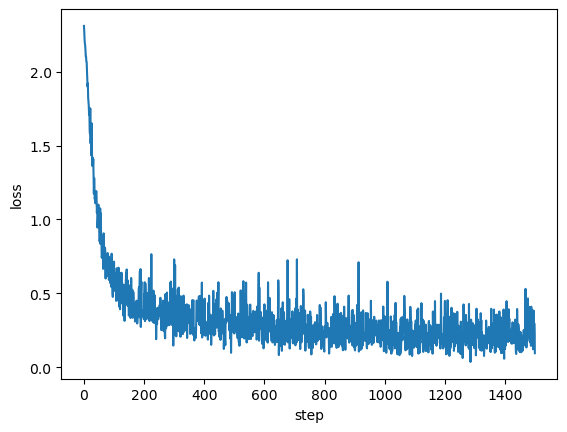

In [ ]:
#| notest

# plt.figure(1)
# plt.subplot(211)
plt.ylabel('loss')
plt.xlabel('step')
plt.plot(losses)
# plt.subplot(212)
# plt.ylabel('lr')
# plt.xlabel('step')
# plt.plot(lrs)

## MLP_X

In [ ]:
#| export

class MLP_X(Classifier, LightningModule):
    def __init__(
            self,
            nnet:MLP,
            num_classes:int,
            optimizer:torch.optim.Optimizer,
            scheduler:torch.optim.lr_scheduler
        ):
        
        logger.info("MLP_X init")
        super().__init__(num_classes, optimizer, scheduler)
        self.nnet = nnet
        self.save_hyperparameters(logger=False,ignore=['nnet'])
        self.lr = optimizer.keywords['lr'] # for lr finder
    
    def forward(self, x:torch.Tensor)->torch.Tensor:
        return self.nnet(x)
    
    def _step(self, batch, batch_idx):
        x, y = batch
        x = x.view(x.size(0), -1)
        y_hat = self.forward(x)
        loss = self.loss(y_hat, y)
        preds = y_hat.argmax(dim=1)
        return loss, preds, y
    
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, y = batch
        x = x.view(x.size(0), -1)
        y_hat = self.forward(x)
        return y_hat.argmax(dim=1)

### Usage

In [ ]:
cfg = OmegaConf.load('../config/image/model/mlp.yaml')
model = instantiate(cfg)
b = torch.rand((16,1, 28*28))
y = model(b)
print(y.shape)

[15:29:42] INFO - MLP: init
[15:29:42] INFO - MLP_X init
[15:29:42] INFO - Classifier: init


torch.Size([16, 1, 10])


### Nimrod training

In [ ]:
#| notest

MAX_EPOCHS = 5
# data module config
cfg = OmegaConf.load('../config/image/data/mnist.yaml')
cfg.datamodule.batch_size = 2048
cfg.datamodule.num_workers = 0
datamodule = instantiate(cfg.datamodule)
datamodule.prepare_data()
datamodule.setup()

# model
cfg = OmegaConf.load('../config/model/image/mlp.yaml')
# 1-cycle sched
cfg.scheduler.total_steps = len(datamodule.train_dataloader()) * MAX_EPOCHS
model = instantiate(cfg)

trainer = Trainer(
    accelerator="auto",
    max_epochs=MAX_EPOCHS,
    logger=CSVLogger("logs", name="mnist_mlp")
    )

trainer.fit(model, datamodule.train_dataloader(), datamodule.val_dataloader())

[16:17:44] INFO - Init ImageDataModule for mnist
[16:18:00] INFO - split train into train/val [0.8, 0.2]
[16:18:00] INFO - train: 48000 val: 12000, test: 10000
[16:18:00] INFO - MLP: init
[16:18:00] INFO - MLP_X init
[16:18:00] INFO - Classifier: init
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
[16:18:00] INFO - Optimizer: AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 1e-05
)
[16:18:00] INFO - Scheduler: <torch.optim.lr_scheduler.OneCycleLR object>

  | Name         | Type               | Params | Mode 
------------------------------------------------------------
0 | loss         | CrossEntropyLoss   | 0      | train
1 | train_acc    | MulticlassAccuracy | 0      | train
2 | val_acc      | MulticlassAccuracy | 0      | train
3 | test_acc     | Mul

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (24) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [ ]:
#| notest
csv_path = f"{trainer.logger.log_dir}/metrics.csv"
metrics = pd.read_csv(csv_path)
metrics.head(5)

,epoch,step,train/acc_epoch,train/acc_step,train/loss_epoch,train/loss_step,val/acc,val/acc_best,val/loss
0,0,23,NaN,NaN,NaN,NaN,0.864333,0.864333,0.459069
1,0,23,0.613167,NaN,1.464963,NaN,NaN,NaN,NaN
2,1,47,NaN,NaN,NaN,NaN,0.917750,0.917750,0.277105
3,1,47,0.879375,NaN,0.397167,NaN,NaN,NaN,NaN
4,2,49,NaN,0.907227,NaN,0.304572,NaN,NaN,NaN


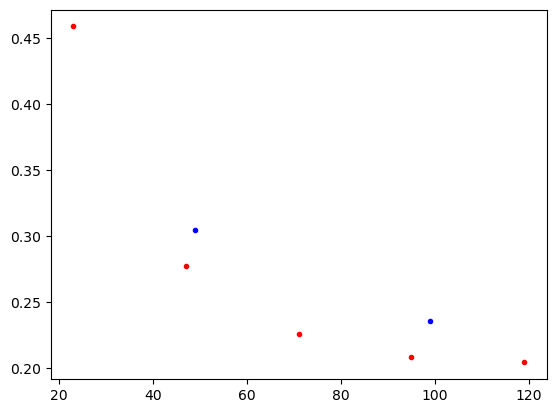

In [ ]:
#| notest
plt.figure()
plt.plot(metrics['step'], metrics['train/loss_step'], 'b.-')
plt.plot(metrics['step'], metrics['val/loss'],'r.-')
plt.show()

In [ ]:
#| notest
trainer.test(model, datamodule.test_dataloader())

/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │    0.9408000111579895     │
│         test/loss         │    0.19908809661865234    │
└───────────────────────────┴───────────────────────────┘

[{'test/loss': 0.19908809661865234, 'test/acc': 0.9408000111579895}]

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()